# High Frequency Sea Ice Volume Variability: Characteristics

## Background and Goals

## Data and Methods

## Functions

#### Required Libraries

In [1]:
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime 

import scipy.signal as signal
import scipy.stats as stats
import statsmodels.api as sm

#### Data Processing

In [2]:
def read_cmip_files(variable, cat):
    """ Read in CMIP6 CESM2 files from the piControl experiements (100 years) """
    
    cmip_dir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/'+cat+'/'+variable+'/gn/files/d20190320/'
    files = sorted(glob.glob(cmip_dir+variable+'_'+cat+'_CESM2_piControl_r1i1p1f1_gn_*[0-9]*'))
    cmip_ds = xr.open_mfdataset(files[-2:-1], combine='by_coords')
    return cmip_ds

def read_historical_files(variable, cat):
    cmip_dir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/'+cat+'/'+variable+'/gn/files/d20190308/'
    files = glob.glob(cmip_dir+variable+'_'+cat+'_CESM2_historical_r1i1p1f1_gn_*[0-9]*')
    cmip_ds = xr.open_dataset(files[0])
    
    return cmip_ds

def read_cesmLE(variable, time_interval):
    """ Read in CESM2 Large ensemble data. Returns an array that is ensemble member x time x space"""
    
    arrays = []
    for i in range(1,11):
        files = sorted(glob.glob('/glade/scratch/mollyw/external_data/CESM2_LE/daily/b.e21.BHISTcmip6.f09_g17.LE2-1*[0-9]*.0{:0>2d}.*[0-9]*.nc'.format(i)))
        
        array_group = xr.open_mfdataset(files, combine='by_coords')
        
        arrays.append(array_group)
        
    final_array = xr.concat(arrays, dim = 'ensemble_member')
    return final_array

def read_CS2():
    file = '/glade/scratch/mollyw/external_data/CryoSat-2/YR_Cryosat-2/ubristol_cryosat2_seaicethickness_nh_80km_v1p7.nc'
    
    ds = xr.open_dataset(file, decode_times=False)
    
    no_days_0001 = ds.Time - 366
    
    time=[]
    for srl_no in no_days_0001.values:
        time.append(datetime.datetime(1,1,1,0,0) + datetime.timedelta(srl_no-1))
    
    ds = ds.rename_dims({'t':'time'})
    ds['time'] = time
    ds = ds.drop("Time")
    
    ds["Sea_Ice_Volume"] = ds.Sea_Ice_Thickness * ds.Sea_Ice_Concentration

    return ds
    
def read_PIOMAS():
    files = sorted(glob.glob('/glade/scratch/mollyw/external_data/PIOMAS/daily/piomas_bin_reader/output/20*[0-9]*.nc'))
    ds_pms = xr.open_mfdataset(files, combine = 'nested', concat_dim = 'year')
    ds_pms = ds_pms.stack(time = ['year','t'])
    
    attrs = {'units': 'days since 2010-01-01'}
    time = xr.Dataset({'time': ('time', np.arange(0, len(ds_pms.time)), attrs)})
    time = xr.decode_cf(time)

    ds_pms["time"] = time.time
    
    return ds_pms
    
def calculate_cmip_volume(cat, nint):
    if cat == 'SIyear':
        cat = 'SImon'
        thickness = read_cmip_files('sithick',cat)
        area = read_cmip_files('siconc', cat)
        volume = thickness.sithick * area.siconc/100
        volume = volume.groupby('time.year').mean(dim = 'time').rename({'year':'time'})
    else:
        thickness = read_cmip_files('sithick',cat)
        area = read_cmip_files('siconc', cat)
        volume = thickness.sithick * area.siconc/100
        
    volume = volume[0:nint,:,:].compute()
    
    return volume

In [3]:
from shapely.geometry import Polygon
import geopandas as gp

In [4]:
def area_weight(latitude,longitude):
    
    # initalize empty lists for the cell data and the thickness data
    grid_cells = []
    
    for x_anchor in range(0, np.shape(latitude)[0]-1):
        for y_anchor in range(0, np.shape(latitude)[1]-1):
            # collecting the latitude (y) and longitude (x) of each of the vertices
            
            x0 = longitude[x_anchor,y_anchor].values
            x1 = longitude[x_anchor,y_anchor + 1].values
            x2 = longitude[x_anchor + 1, y_anchor + 1].values
            x3 = longitude[x_anchor + 1, y_anchor].values
  
            y0 = latitude[x_anchor,y_anchor].values
            y1 = latitude[x_anchor,y_anchor + 1].values
            y2 = latitude[x_anchor + 1, y_anchor + 1].values
            y3 = latitude[x_anchor + 1, y_anchor].values

            # otherwise, generate a Polygon from the corners and store it in the
            # list along with the thickness value of the grid cell
            grid_cells.append(Polygon([(x0, y0), (x1, y1), (x2, y2), (x3, y3)]))

    # turn the Polygons into a GeoDataFrame with the standard WGS84 CRS
    cell = gp.GeoDataFrame(grid_cells, columns=['geometry'], crs='epsg:3411')
    areas = cell.area.to_xarray()
    
    areas = areas.values.reshape(np.shape(latitude)[0]-1,np.shape(latitude)[1]-1)
    
    return areas

#### Methods

In [5]:
def difference(dataset, interval=1):
    """ Calculate the difference between two timesteps of a timeseries at a prescribed 
        interval.
        
        Inputs: xr.DataArray or xr.DataSet timeseries
        Output: differenced array as an xr.DataArray
    """
    
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    
    diff_array = xr.DataArray(diff, 
                              coords=dataset.isel(time = slice(0,-1*interval)).coords, 
                              dims=dataset.isel(time = slice(0,-1*interval)).dims, 
                              attrs=dataset.isel(time = slice(0,-1*interval)).attrs
                             )
    return diff_array

def variability_in_window(timeseries, low, high, fs = 1):
    
    # determine filter
    nyquist = fs / 2
    print('low cutoff= ',1/low*nyquist,' days')
    print('high cutoff= ',1/high*nyquist,' days')
    
    sos = signal.butter(5, [low, high], btype='bandpass', output='sos')
    
    filtered = signal.sosfiltfilt(sos, timeseries, axis = 0)
    filtered = xr.DataArray(filtered,
                            coords = timeseries.coords,
                            dims = timeseries.dims,
                            attrs = timeseries.attrs
                           )
    hfsit = filtered.groupby('time.month').std(dim='time')
    
    return hfsit

def detrend_data(data):

    data = data.groupby('time.month') - data.groupby('time.month').mean(dim='time')
    
    results = data.polyfit(dim='time', deg=1)
    trend = xr.polyval(data.time, results.polyfit_coefficients)
    
    # subtract trendline from data 
    new_data = data-trend 

    slope = (trend[-1] - trend[0])/len(trend)
    
    return new_data

## Analysis

In [6]:
# # pull in 10 years of gc thickness from historical
hist_per_grid = read_historical_files('sithick','SIday')
hist_conc = read_historical_files('siconc','SIday')
hist_conc = hist_conc.sel(time=slice('2004-01-02', '2014-01-02')).siconc/100
hist_per_grid = hist_per_grid.sel(time=slice('2004-01-02', '2014-01-02')).sithick * hist_conc

# # pull in the CS2 data
cs2_per_grid = read_CS2()

# # pull in PIOMAS data
piomas_per_grid = read_PIOMAS()
piomas_per_grid = piomas_per_grid.sel(time = slice('2011-01-01','2021-01-01'))

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'siconc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


In [7]:
# volume_per_grid = volume_per_grid.compute()
hist_volume_per_grid = hist_per_grid.compute()
hist_conc = hist_conc.compute()
cs2_per_grid = cs2_per_grid.compute()
piomas_per_grid = piomas_per_grid.compute()

#### Mean SIT and Total SIV

In [8]:
# average over the Northern Hemisphere
hist_thick = hist_per_grid.where(hist_per_grid > 0).where(hist_per_grid.lat > 0).mean(dim=['ni','nj'])
csthick = cs2_per_grid.where(cs2_per_grid.Sea_Ice_Thickness > 0).where(cs2_per_grid.Latitude > 0).mean(dim=['x','y'])
pmsthick = piomas_per_grid.where(piomas_per_grid.thickness > 0).mean(dim = ['x','y'])

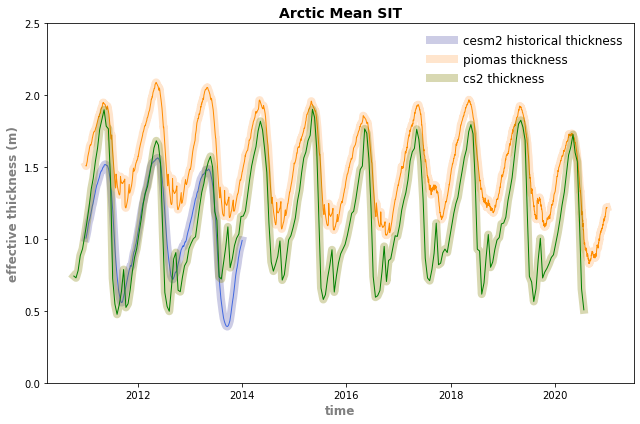

In [159]:
figure = plt.figure(figsize=(9,6))
plt.plot(pmsthick.time[0:365*3+1], hist_thick[-365*3-1:], c= 'navy', linewidth = 8, alpha = 0.2, label = 'cesm2 historical thickness')
plt.plot(pmsthick.time[0:365*3+1], hist_thick[-365*3-1:], c= 'royalblue', linewidth = 1)
plt.plot(pmsthick.time, pmsthick.thickness, c='peachpuff', linewidth = 8, alpha= 0.7, label = 'piomas thickness')
plt.plot(pmsthick.time, pmsthick.thickness, c='darkorange', linewidth = 1)
plt.plot(csthick.time, csthick.Sea_Ice_Volume, c='olive', linewidth = 8, alpha= 0.3, label = 'cs2 thickness')
plt.plot(csthick.time, csthick.Sea_Ice_Volume, c='green', linewidth = 1)
plt.ylim([0, 2.5]) 

plt.xlabel('time', fontsize = '12', fontweight = 'bold', color = 'grey')
plt.ylabel('effective thickness (m)', fontsize = '12', fontweight = 'bold', color = 'grey')
plt.title('Arctic Mean SIT', fontsize = '14', fontweight = 'bold')
plt.legend(fontsize=12, frameon=False)
plt.tight_layout()

In [8]:
area_file = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/v20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
ds_area = xr.open_dataset(area_file)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


In [9]:
ds_area = ds_area.areacello

In [10]:
ds_area = ds_area.drop('lat')
ds_area = ds_area.drop('lon')

In [11]:
cesm2_area = ds_area.rename({'nlat':'nj','nlon':'ni'})

In [12]:
cesm2_area = cesm2_area * 1e-9

In [13]:
cs2_area = area_weight(cs2_per_grid.Latitude, cs2_per_grid.Longitude)
pms_area = area_weight(piomas_per_grid.latitude, piomas_per_grid.longitude)

In [14]:
# calculate total sea ice volume
hist_weighted = hist_per_grid.where(hist_per_grid.lat > 0)*cesm2_area
hist_volume = hist_weighted.sum(dim=['ni','nj'])

cs2_weighted = cs2_per_grid.Sea_Ice_Volume.where(cs2_per_grid.Latitude > 0)[:,0:-1, 0:-1]*cs2_area
cs2_volume = cs2_weighted.sum(dim=['x','y'])

pms_weighted = piomas_per_grid.thickness[0:-1, 0:-1, :].transpose('time','x','y') * pms_area
pms_volume = pms_weighted.sum(dim = ['x','y'])

# ensuring data is loaded into system
hist_volume = hist_volume.compute()
cs2_volume = cs2_volume.compute()
pms_volume = pms_volume.compute()

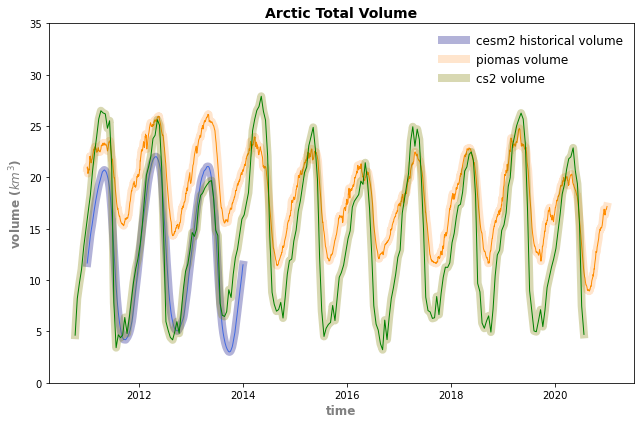

In [167]:
figure = plt.figure(figsize=(9,6))
plt.plot(pmsthick.time[0:365*3+1], hist_volume[-365*3-1:]*1e-3, c='navy', linewidth=8, alpha=0.3, label='cesm2 historical volume')
plt.plot(pmsthick.time[0:365*3+1], hist_volume[-365*3-1:]*1e-3, c= 'royalblue', linewidth = 1)
plt.plot(pmsthick.time, pms_volume*1e-3, c='peachpuff', linewidth = 8, alpha= 0.7, label = 'piomas volume')
plt.plot(pmsthick.time, pms_volume*1e-3, c='darkorange', linewidth = 1)
plt.plot(csthick.time, cs2_volume*1e-3, c='olive', linewidth = 8, alpha= 0.3, label = 'cs2 volume')
plt.plot(csthick.time, cs2_volume*1e-3, c='green', linewidth = 1)
plt.ylim([0, 35])

plt.xlabel('time', fontsize = '12', fontweight = 'bold', color = 'grey')
plt.ylabel('volume ($km^3$)', fontsize = '12', fontweight = 'bold', color = 'grey')
plt.title('Arctic Total Volume', fontsize = '14', fontweight = 'bold')
plt.legend(fontsize=12, frameon=False)
plt.tight_layout()

#### Detrended/Deseasonalized SIV

In [25]:
pms_volume = pms_volume.drop('day')

In [26]:
# detrend and deseasonalize all data

# detrend
# mod_detrended = mod_volume.diff(dim='time', n=1)
hist_detrended = detrend_data(hist_volume)
obs_detrended = detrend_data(cs2_volume)
pio_detrended = detrend_data(pms_volume)

# # deseasonalize
# # mod_deseasonalized = difference(mod_detrended, 365)
# hist_deseasonalized = difference(hist_detrended, 365)
# obs_deseasonalized = difference(obs_detrended, 365)
# pio_deseasonalized = difference(pio_detrended, 365)

In [174]:
hist_detrended

<xarray.DataArray (time: 3651)>
array([-2043.99336118, -1899.20416141, -1757.49796946, ...,
        1917.44878866, -1805.14384751, -1717.42593681])
Coordinates:
  * time     (time) object 2004-01-02 00:00:00 ... 2014-01-02 00:00:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 1 1

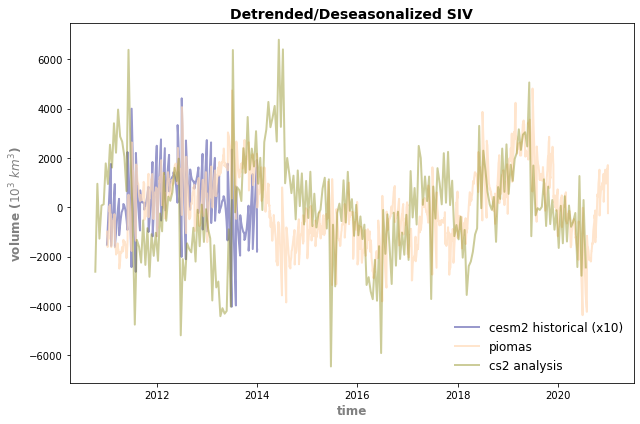

In [249]:
figure = plt.figure(figsize=(9, 6))
plt.plot(pio_detrended.time[0:365*3+1], hist_detrended[-365*3-1:],
         c='navy',
         linewidth=2,
         alpha=0.4,
         label='cesm2 historical (x10)')
# plt.plot(hist_deseasonalized, c= 'royalblue', linewidth = 1)
plt.plot(pio_detrended.time, pio_detrended, c='peachpuff', linewidth = 2, alpha= 0.7, label = 'piomas')
# plt.plot(pio_deseasonalized, c='darkorange', linewidth = 1)
plt.plot(obs_detrended.time, obs_detrended,
         c='olive',
         linewidth=2,
         alpha=0.4,
         label='cs2 analysis')
# plt.plot(obs_deseasonalized, c='green', linewidth = 1)

plt.xlabel('time', fontsize = '12', fontweight = 'bold', color = 'grey')
plt.ylabel('volume ($10^3$ $km^3$)', fontsize = '12', fontweight = 'bold', color = 'grey')
plt.title('Detrended/Deseasonalized SIV', fontsize = '14', fontweight = 'bold')
plt.legend(fontsize=12, frameon=False)
plt.tight_layout()

#### Arctic HFVSIV

In [27]:
# put workable values in to the empty obs 
# obs_detrended = obs_detrended.fillna(0)

# load deasonalized data into a dictionary
deseasonalized = {'hist':hist_detrended, 'obs':obs_detrended, 'piomas':pio_detrended}
# deseasonalized = {'hist':hist_deseasonalized,'obs':obs_deseasonalized}

low cutoff=  10.0  days
high cutoff=  3.0  days
low cutoff=  20.0  days
high cutoff=  10.0  days
low cutoff=  30.0  days
high cutoff=  20.0  days
low cutoff=  40.0  days
high cutoff=  30.0  days
low cutoff=  50.0  days
high cutoff=  40.0  days
low cutoff=  60.0  days
high cutoff=  50.0  days
low cutoff=  10.0  days
high cutoff=  7.507507507507508  days
low cutoff=  20.0  days
high cutoff=  10.0  days
low cutoff=  30.0  days
high cutoff=  20.0  days
low cutoff=  40.0  days
high cutoff=  30.0  days
low cutoff=  50.0  days
high cutoff=  40.0  days
low cutoff=  60.0  days
high cutoff=  50.0  days
low cutoff=  10.0  days
high cutoff=  3.0  days
low cutoff=  20.0  days
high cutoff=  10.0  days
low cutoff=  30.0  days
high cutoff=  20.0  days
low cutoff=  40.0  days
high cutoff=  30.0  days
low cutoff=  50.0  days
high cutoff=  40.0  days
low cutoff=  60.0  days
high cutoff=  50.0  days


/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify

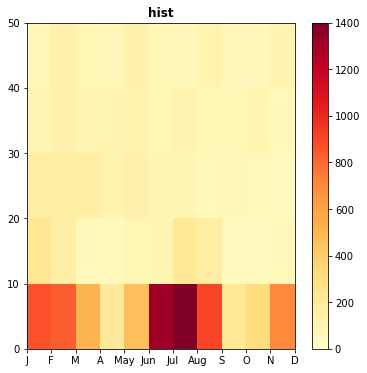

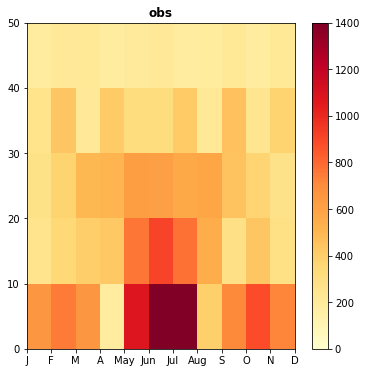

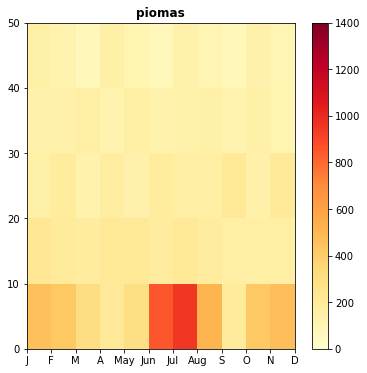

In [28]:
# set up a loop to calculate and plot the HFVSIV for each source of data
# labels = ['lens1','lens2','lens3','lens4','lens5','total']
labels = ['hist','obs','piomas']
cutoffs_mods = [1/6, 1/20, 1/40, 1/60, 1/80, 1/100, 1/120]
cutoffs_obs = [999/1000, 3/4, 7.5/20, 7.5/30, 7.5/40, 7.5/50, 7.5/60] 
HFSIT = {}

months = ['J','F','M','A','May','Jun','Jul','Aug','S','O','N','D']
# months = ['DJF','MAM','JJA','SON']
days = [0,10, 20,30,40,50]

for label in labels:
    
    if label == 'obs':
        fs = 15
        cutoffs = cutoffs_obs
    else:
        fs = 1
        cutoffs = cutoffs_mods
        
    timeseries = deseasonalized[label]

    # timeseries = deseasonalized[label]

    # initalize list for each window
    list_hfsit = []

    # solve each window and append to list
    for i in range(0, len(cutoffs[:-1])):
        hfsit = variability_in_window(timeseries, cutoffs[i+1], cutoffs[i], fs = fs)
        list_hfsit.append(hfsit)

    # combine records 
    HFSIT[label] = xr.concat(list_hfsit, dim = 'intervals')

    fig = plt.figure(figsize = (6, 6))


    cmap = plt.cm.YlOrRd
    # norm = colors.BoundaryNorm(np.arange(0, 100, 5), cmap.N)

    plt.pcolormesh(months, days, HFSIT[label], vmin = 0, vmax=1400, cmap = cmap)
    plt.title(label, fontweight = 'bold', fontsize =12)
    plt.colorbar()

In [29]:
check = 'hist'
# scaling = HFSIT['obs'].mean(dim='month')/HFSIT[check].mean(dim='month')
model = HFSIT[check]
obs = HFSIT['obs']

In [30]:
diff = obs - model
ratio = obs/model

In [31]:
import seaborn as sns

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


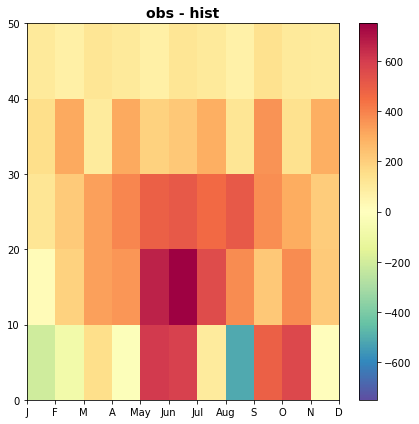

In [32]:
# plot the heatmap-- eventually get seaborn to do this, it's prettier
months = ['J','F','M','A','May','Jun','Jul','Aug','S','O','N','D']
# months = ['DJF','MAM','JJA','SON']
days = [0,10, 20,30,40,50]

fig = plt.figure(figsize = (6, 6))

# cmap = sns.color_palette('icefire')

plt.pcolormesh(months, days, diff, vmin = -750, vmax = 750, cmap = 'Spectral_r')
plt.title('obs - ' + check, fontweight = 'bold', fontsize=14)
plt.colorbar()
plt.tight_layout()

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


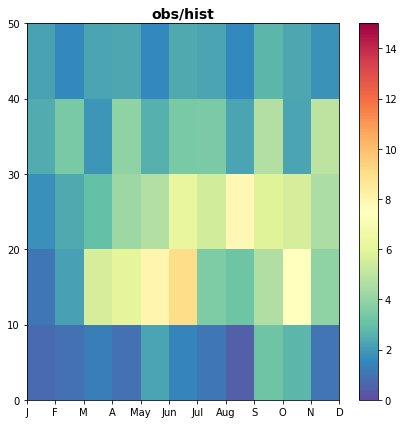

In [33]:
# plot the heatmap-- eventually get seaborn to do this, it's prettier
months = ['J','F','M','A','May','Jun','Jul','Aug','S','O','N','D']
# months = ['DJF','MAM','JJA','SON']
days = [0,10, 20,30,40,50]

fig = plt.figure(figsize = (6, 6))

# cmap = plt.cm.YlGnBu
# norm = colors.BoundaryNorm(np.linspace(0, 10, 21), cmap.N)

plt.pcolormesh(months, days, ratio, vmin = 0 , vmax = 15, cmap = 'Spectral_r')
plt.colorbar()
plt.title('obs/'+check, fontweight='bold', fontsize=14)
plt.tight_layout()

#### Antarctic HFVSIT

In [ ]:
# isolate the Antarctic 
volume = volume_per_grid.where(volume_per_grid.lat < -50).sum(dim=['ni','nj'])

# detrend
detrended = volume.diff(dim = 'time', n = 1)
    
# deseasonalize
deseasonalized = difference(detrended, 365)

In [ ]:
# determine window bounds
cutoffs = [1/6, 1/20, 1/40, 1/60, 1/80, 1/100, 1/120]

# initalize list for each window
list_hfsit = []

# solve each window and append to list
for i in range(0, len(cutoffs[:-1])):
    hfsit = variability_in_window(deseasonalized, cutoffs[i+1], cutoffs[i])
    list_hfsit.append(hfsit)

# combine records 
HFSIT = xr.concat(list_hfsit, dim = 'intervals')

In [ ]:
# plot the heatmap-- eventually get seaborn to do this, it's prettier
# months = ['J','F','M','A','May','Jun','Jul','Aug','S','O','N','D']
months = ['DJF','MAM','JJA','SON']
days = [5,15, 25,35,45,55]

fig = plt.figure(figsize = (6, 6))

cmap = plt.cm.YlOrRd
norm = colors.BoundaryNorm(np.arange(0, 17, 2), cmap.N)

plt.pcolormesh(months, days, HFSIT, cmap = cmap, norm=norm)
plt.colorbar()

#### Spectral Analysis: WOSA

[14.22222222 12.8        11.63636364 10.66666667  9.84615385  9.14285714
  8.          7.52941176  7.11111111  6.73684211  6.4         6.0952381
  5.81818182  5.56521739  5.33333333  5.12        4.92307692  4.74074074
  4.57142857  4.26666667  3.87878788]
[21.33333333 12.8        11.63636364  9.14285714  8.53333333  8.
  7.52941176  7.11111111  6.73684211  6.4         6.0952381   5.81818182
  5.56521739  5.33333333  5.12        4.92307692  4.74074074  4.57142857
  4.4137931   4.26666667]
[32.         25.6        21.33333333 18.28571429 14.22222222  2.13333333
  2.09836066  2.06451613  2.03174603]


/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,
/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/statsmodels/tsa/s

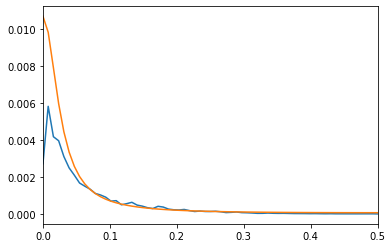

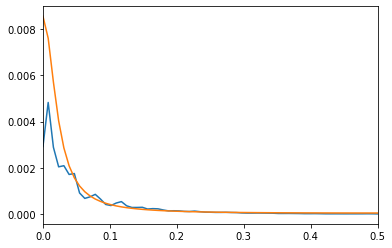

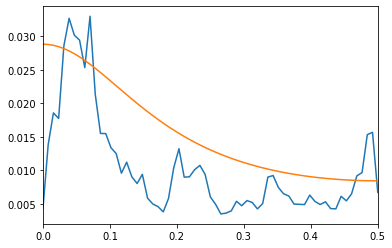

In [135]:
fw = 1.2
for label in labels:
    timeseries = deseasonalized[label]
    # if label == 'obs':
    #     timeseries = timeseries/10
    # elif label == 'piomas':
    #     timeseries = timeseries/5

    f0, Pxx0 = signal.welch(timeseries, fs=1, window = 'hann', nperseg=128, detrend = False, axis = 0)

    a0 = sm.tsa.acf(timeseries)[1]

    N = len(timeseries)
    M = 128
    dof = 2*N/M*fw

    f_stat = stats.f.ppf(0.95, dof, dof)

    red0 = [(1-a0**2)/(1-2*a0*np.cos(omega)+a0**2) for omega in np.linspace(0, np.pi, len(f0))]
    ratio0 = sum(Pxx0)/sum(red0)
    Red0 = [r0*ratio0*f_stat for r0 in red0]

    fig = plt.figure()
    plt.plot(f0, Pxx0)
    plt.plot(f0, Red0)
    plt.xlim([0.0, 0.5])
    # plt.ylim([0, 5000])

    indexes = np.where(Pxx0 - Red0 > 0)
    # print(indexes)
    periods = [1/f0[i] for i in indexes]
    print(periods[0])